# Step 1: Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Step 2: Load and Preprocess the Data

In [2]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Step 3: Define and Train Models with Different Configurations

In [4]:
# Define configurations
configurations = [
    {"layers": [128, 64], "optimizer": SGD(learning_rate=0.01)},
    {"layers": [256, 128], "optimizer": Adam(learning_rate=0.001)},
    {"layers": [128, 128, 64], "optimizer": RMSprop(learning_rate=0.001)},
]

results = {}

for i, config in enumerate(configurations):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    for neurons in config["layers"]:
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=config["optimizer"],
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"\nTraining Model {i+1} with {config['layers']} layers and {type(config['optimizer']).__name__}")
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, batch_size=32, verbose=1)

    # Store results
    results[f"Model_{i+1}"] = {
        "model": model,
        "history": history.history
    }

E:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training Model 1 with [128, 64] layers and SGD
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5399 - loss: 1.4393 - val_accuracy: 0.8996 - val_loss: 0.3679
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8521 - loss: 0.4932 - val_accuracy: 0.9186 - val_loss: 0.2821
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8822 - loss: 0.3984 - val_accuracy: 0.9312 - val_loss: 0.2383
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9031 - loss: 0.3361 - val_accuracy: 0.9385 - val_loss: 0.2128
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9104 - loss: 0.2982 - val_accuracy: 0.9453 - val_loss: 0.1916
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9231 - loss: 0.2670 - val_accuracy: 0.9488 - val_loss: 0.1777
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9273 - loss: 0.2506 - val_accuracy: 0.9524 - val_loss: 0.1670
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━

# Step 4: Evaluate and Visualize the Results

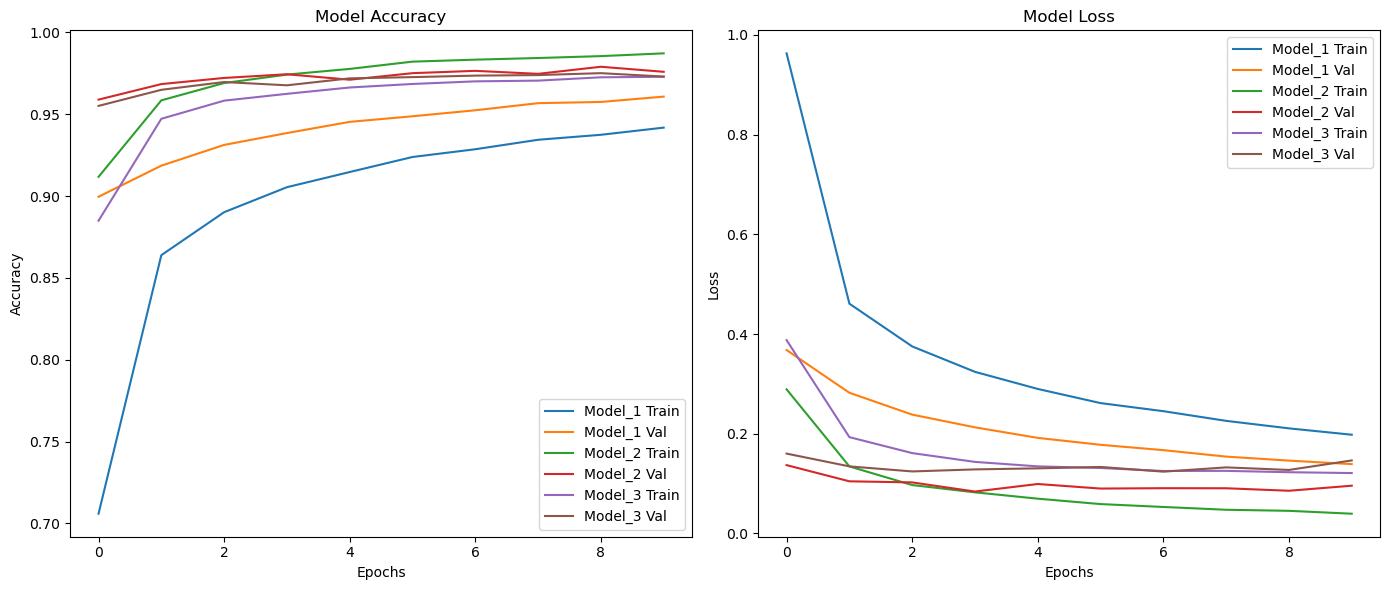

Model_1: Test Accuracy = 0.9600, Test Loss = 0.1345
Model_2: Test Accuracy = 0.9797, Test Loss = 0.0761
Model_3: Test Accuracy = 0.9728, Test Loss = 0.1233


In [5]:
# Plot accuracy and loss
plt.figure(figsize=(14, 6))

for i, (key, result) in enumerate(results.items()):
    history = result["history"]
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label=f"{key} Train")
    plt.plot(history['val_accuracy'], label=f"{key} Val")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label=f"{key} Train")
    plt.plot(history['val_loss'], label=f"{key} Val")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the best model
for key, result in results.items():
    test_loss, test_acc = result["model"].evaluate(x_test, y_test, verbose=0)
    print(f"{key}: Test Accuracy = {test_acc:.4f}, Test Loss = {test_loss:.4f}")

In [6]:
#!pip install keras_tuner

# Advanced Step 1: Hyperparameter Tuning with Keras Tuner

In [9]:
import keras_tuner as kt

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of layers and neurons
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                        activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    # Tune the optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner_results',
                     project_name='mnist_tuning')

# Perform hyperparameter search
tuner.search(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Reloading Tuner from tuner_results\mnist_tuning\tuner0.json

Best Hyperparameters:
num_layers: 3
units_0: 192
dropout_0: 0.30000000000000004
optimizer: rmsprop
units_1: 128
dropout_1: 0.1
units_2: 256
dropout_2: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


E:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8156 - loss: 0.5824 - val_accuracy: 0.9556 - val_loss: 0.1585
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9477 - loss: 0.1941 - val_accuracy: 0.9695 - val_loss: 0.1182
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9558 - loss: 0.1642 - val_accuracy: 0.9716 - val_loss: 0.1166
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9621 - loss: 0.1540 - val_accuracy: 0.9700 - val_loss: 0.1244
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9662 - loss: 0.1428 - val_accuracy: 0.9733 - val_loss: 0.1178
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9659 - loss: 0.1482 - val_accuracy: 0.9725 - val_loss: 0.1244
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9695 - loss: 0.1389 - val_accuracy: 0.9742 - val_loss: 0.1333
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9690 - loss: 0.1398

In [10]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    # Tune the number of layers and neurons
    for i in range(hp.Int('num_layers', 1, 3)):  # Tune number of layers (1 to 2)
        model.add(Dense(
            hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),  # Tune neurons
            activation='relu'
        ))
        model.add(Dropout(
            hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)  # Tune dropout
        ))

    model.add(Dense(10, activation='softmax'))

    # Tune optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    if optimizer == 'adam':
        optimizer_instance = Adam()
    elif optimizer == 'sgd':
        optimizer_instance = SGD()
    else:
        optimizer_instance = RMSprop()

    model.compile(
        optimizer=optimizer_instance,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,  # Max epochs for each trial
    factor=3,  # Reduction factor for resources
    directory='tuner_results',
    project_name='mnist_tuning'
)

# Perform hyperparameter search
tuner.search(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,  # Total epochs per trial
    batch_size=32,
    verbose=1  # Show progress
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full training data
history = best_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,  # Final training epochs
    batch_size=32
)

# Save the best model
best_model.save('best_mnist_model.h5')


Reloading Tuner from tuner_results\mnist_tuning\tuner0.json

Best Hyperparameters:
num_layers: 3
units_0: 192
dropout_0: 0.30000000000000004
optimizer: rmsprop
units_1: 128
dropout_1: 0.1
units_2: 256
dropout_2: 0.4
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8137 - loss: 0.5872 - val_accuracy: 0.9575 - val_loss: 0.1524
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9483 - loss: 0.1865 - val_accuracy: 0.9684 - val_loss: 0.1218
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9573 - loss: 0.1608 - val_accuracy: 0.9704 - val_loss: 0.1233
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9612 - loss: 0.1488 - val_accuracy: 0.9671 - val_loss: 0.1281
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9667 - loss: 0.1454 - val_accuracy: 0.9737 - val_loss: 0.1264
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accur

# Advanced Step 2: Explainability with Grad-CAM

# !pip install opencv-python

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


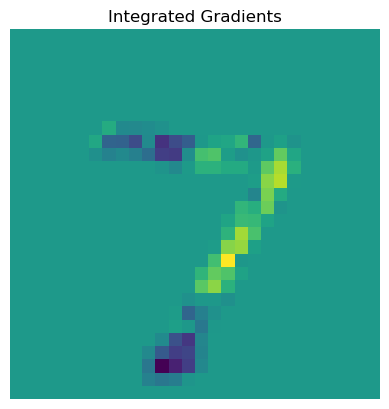

In [14]:
def integrated_gradients(model, img, target_class_idx, baseline=None, steps=50):
    """
    Compute Integrated Gradients for a given image and model.

    Parameters:
    - model: Trained Keras model
    - img: Input image (preprocessed)
    - target_class_idx: Index of the target class
    - baseline: Baseline image (default is black image)
    - steps: Number of steps for interpolation

    Returns:
    - Integrated gradients as a numpy array
    """
    if baseline is None:
        baseline = np.zeros_like(img)  # Use a black image as baseline

    # Scale input and baseline
    img = tf.cast(img, tf.float32)
    baseline = tf.cast(baseline, tf.float32)

    # Interpolate images
    interpolated_images = [
        baseline + (float(i) / steps) * (img - baseline)
        for i in range(steps + 1)
    ]
    interpolated_images = tf.convert_to_tensor(interpolated_images)

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        preds = model(interpolated_images)
        loss = preds[:, target_class_idx]

    grads = tape.gradient(loss, interpolated_images)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()

    # Integrated gradients
    integrated_grads = (img - baseline) * avg_grads
    return integrated_grads

# Ensure example_img has the correct shape
if len(example_img.shape) == 3 and example_img.shape[-1] == 3:  # RGB image
    example_img = example_img.astype("float32") / 255.0  # Normalize

elif len(example_img.shape) == 2:  # Grayscale image
    example_img = example_img.astype("float32") / 255.0
else:
    raise ValueError(f"Invalid input shape: {example_img.shape}")

# Compute integrated gradients
target_class = np.argmax(best_model.predict(np.expand_dims(example_img, axis=0)))
integrated_grads = integrated_gradients(best_model, example_img, target_class)

# Ensure gradients have the same shape as input
if len(integrated_grads.shape) == 3:  # RGB image
    visualization = np.mean(integrated_grads, axis=-1)  # Average over color channels
elif len(integrated_grads.shape) == 2:  # Grayscale image
    visualization = integrated_grads
else:
    raise ValueError(f"Invalid integrated gradients shape: {integrated_grads.shape}")

# Visualize
plt.imshow(visualization, cmap='viridis')
plt.title("Integrated Gradients")
plt.axis('off')
plt.show()


# Image Classification using MNIST Dataset

# load dataset

# observed shape of the dataset

# view few images

# model building

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [25]:
(trainX,trainY),(testX,testY) = tf.keras.datasets.mnist.load_data()

In [26]:
print(trainX.shape)  #total 60000 images easch with size 28*28 pixels
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [27]:
np.set_printoptions(linewidth=200)
trainX[0] #displaying pixel

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170, 253, 253, 253, 253, 253, 225, 172

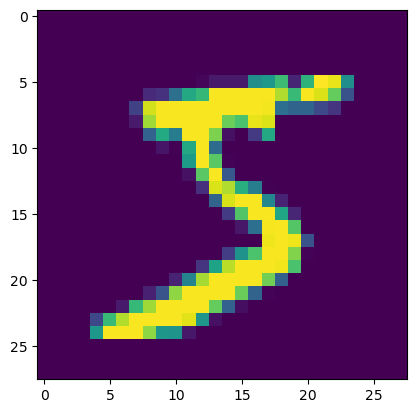

In [28]:
plt.imshow(trainX[0]) #Displayin image

In [29]:
trainY[0]  # the first image represents the digit 5

5

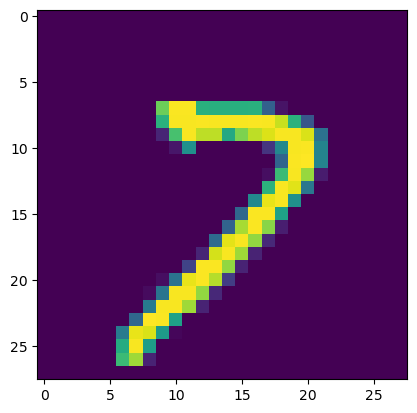

In [30]:
plt.imshow(trainX[567])

In [31]:
trainY[567]

7

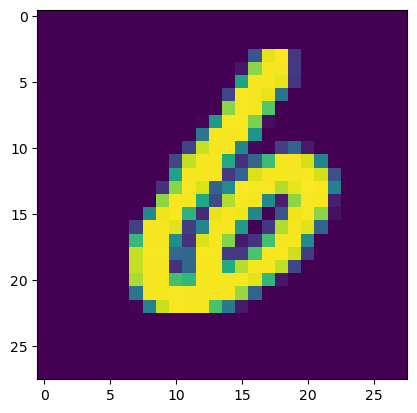

In [32]:
plt.imshow(testX[8901])

In [33]:
testY[8901]

6

In [34]:
#trainY = tf.keras.utils.to_categorical(trainY,num_classes=10)
#testY = tf.keras.utils.to_categorical(testY,num_classes=10)

In [35]:
#trainY[0]

In [36]:
tf.keras.backend.clear_session() #remove the default graph ,if any

#intialize Sequential Model
model = tf.keras.models.Sequential()
#Reshape data from 2D to 1D -> 28*28 to 784
#use reshape() or you can use Flatten() also.

#This is because ,NN cannot handle 2-D data.it always needs a 1D vector.
model.add(tf.keras.layers.Reshape((784,),input_shape=(28,28,)))

#Normalize the Data
#BatchNormalization takes a batch of data and performs z-Score normalization by taking mean and std of that batch of data
model.add(tf.keras.layers.BatchNormalization()) #x-mean/std


#Alternatively,the following code does min-max normalization
#trainX,testX = trainX/255.0,testX/255.0

model.add(tf.keras.layers.Dense(200,activation='sigmoid'))   #Add 1st hidden layers
model.add(tf.keras.layers.Dense(100,activation='sigmoid'))   #Add 2nd hidden layers
model.add(tf.keras.layers.Dense(60,activation='sigmoid'))    #Add 3rd hiddem layers
model.add(tf.keras.layers.Dense(30,activation='sigmoid'))    #Add 4th hidden layers
model.add(tf.keras.layers.Dense(10,activation='softmax'))    #Add output layers


E:\Anaconda\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 784)                 │           3,136 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │         157,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 60)                  │           6,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             310 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 188,436 (736.08 KB)

 Trainable params: 186,868 (729.95 KB)

 Non-trainable params: 1,568 (6.12 KB)

In [38]:
# Create Optimizer With Non-Default Learning Rate

sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

#Compile The Model
model.compile(optimizer=sgd_optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
#model.fit(trainX,trainY,validation_data=(testX,testY),epochs=30,batch_size=32)

In [40]:
history = model.fit(trainX,trainY,validation_data=(testX,testY),epochs=30,batch_size=32)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1125 - loss: 2.3058 - val_accuracy: 0.2296 - val_loss: 2.2769
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.2354 - loss: 2.2324 - val_accuracy: 0.4247 - val_loss: 1.6816
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4440 - loss: 1.5255 - val_accuracy: 0.5761 - val_loss: 1.1965
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6032 - loss: 1.1605 - val_accuracy: 0.7718 - val_loss: 0.8664
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7816 - loss: 0.8051 - val_accuracy: 0.8557 - val_loss: 0.5538
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8439 - loss: 0.5683 - val_accuracy: 0.8800 - val_loss: 0.4507
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8689 - loss: 0.4733 - val_accuracy: 0.8933 - val_loss: 0.3897
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8834 - loss: 0.4144 - 

In [41]:
import pandas as pd

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,accuracy,loss,val_accuracy,val_loss,epoch
25,0.979867,0.070497,0.9657,0.129806,25
26,0.981217,0.065398,0.9676,0.126447,26
27,0.981650,0.062670,0.9654,0.135780,27
28,0.983417,0.058473,0.9682,0.122048,28
29,0.984100,0.054565,0.9660,0.130843,29


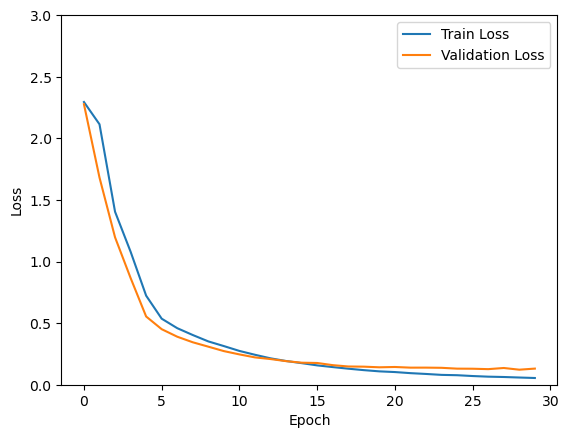

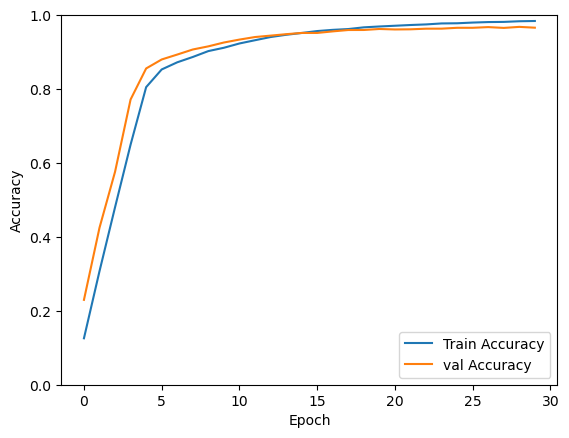

In [43]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],label = 'Validation Loss')
    plt.ylim([0,3])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'],hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'],hist['val_accuracy'],label = 'val Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.show()
plot_history(history)

# Evaluate Accuracy

In [44]:
test_loss,test_acc = model.evaluate(testX,testY,verbose=0)

In [45]:
predictions = model.predict(testX)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [46]:
predictions[0]

array([3.1583037e-05, 3.9492847e-05, 1.7094451e-04, 1.5615896e-04, 1.7695267e-05, 3.3750453e-07, 3.3242258e-09, 9.9897897e-01, 5.6639415e-08, 6.0482655e-04], dtype=float32)

In [47]:
import numpy as np
np.argmax(predictions[0])

7

In [48]:
testY[0]

7

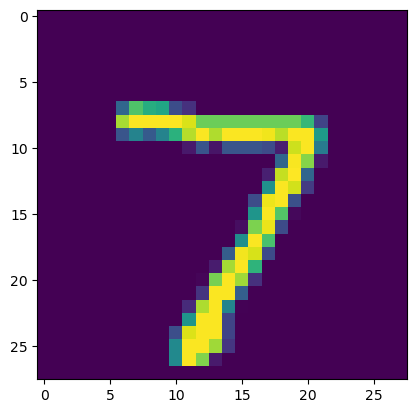

In [49]:
plt.imshow(testX[0])

In [50]:
#trainY = tf.keras.utils.to_categorical(trainY,num_classes=10)
#testY = tf.keras.utils.to_categorical(testY,num_classes=10)

In [51]:
#trainY[0]

# confusion Matrix

In [52]:
from sklearn.metrics import confusion_matrix   #multilabel_confusion_matrix

In [53]:
confusion_matrix = confusion_matrix(testY, np.argmax(predictions, axis=1))

In [54]:
print(confusion_matrix)

[[ 961    1    3    0    0    3    6    4    1    1]
 [   0 1122    5    1    0    0    1    1    5    0]
 [   6    4  997    8    2    1    3   10    1    0]
 [   0    0   12  975    0    5    1    6   10    1]
 [   1    0    4    0  950    0   10    4    1   12]
 [   2    1    1   18    1  856    4    1    7    1]
 [   4    4    6    0    3    8  926    0    7    0]
 [   5    5   14    7    3    0    0  981    0   13]
 [   0    0   11    6    1   15    2    3  933    3]
 [   4    3    2   10   14    3    0    7    7  959]]


In [55]:
confusion_matrix[0]

array([961,   1,   3,   0,   0,   3,   6,   4,   1,   1], dtype=int64)

In [56]:
df=pd.DataFrame(confusion_matrix,columns=np.arange(0,10),index=np.arange(0,10))

In [57]:
df

,0,1,2,3,4,5,6,7,8,9
0,961,1,3,0,0,3,6,4,1,1
1,0,1122,5,1,0,0,1,1,5,0
2,6,4,997,8,2,1,3,10,1,0
3,0,0,12,975,0,5,1,6,10,1
4,1,0,4,0,950,0,10,4,1,12
5,2,1,1,18,1,856,4,1,7,1
6,4,4,6,0,3,8,926,0,7,0
7,5,5,14,7,3,0,0,981,0,13
8,0,0,11,6,1,15,2,3,933,3
9,4,3,2,10,14,3,0,7,7,959


In [58]:
confusion_matrix

array([[ 961,    1,    3,    0,    0,    3,    6,    4,    1,    1],
       [   0, 1122,    5,    1,    0,    0,    1,    1,    5,    0],
       [   6,    4,  997,    8,    2,    1,    3,   10,    1,    0],
       [   0,    0,   12,  975,    0,    5,    1,    6,   10,    1],
       [   1,    0,    4,    0,  950,    0,   10,    4,    1,   12],
       [   2,    1,    1,   18,    1,  856,    4,    1,    7,    1],
       [   4,    4,    6,    0,    3,    8,  926,    0,    7,    0],
       [   5,    5,   14,    7,    3,    0,    0,  981,    0,   13],
       [   0,    0,   11,    6,    1,   15,    2,    3,  933,    3],
       [   4,    3,    2,   10,   14,    3,    0,    7,    7,  959]], dtype=int64)

In [59]:
l=[]
for i in range(0,10):
    ct=0
    for j in range(0,10):
        if i!=j:
            ct=ct+confusion_matrix[i][j]
    l.append(ct)

In [60]:
print(l)

[19, 13, 35, 35, 32, 36, 32, 47, 41, 50]


In [61]:
confusion_matrix[0][2]

3

In [62]:
df2 = pd.DataFrame(l,columns=['misclassification'])

In [63]:
df2

,misclassification
0,19
1,13
2,35
3,35
4,32
5,36
6,32
7,47
8,41
9,50


In [64]:
predictions[l]

array([[6.61396698e-05, 5.64913250e-07, 9.60175894e-05, 3.02530601e-09, 9.98840272e-01, 2.88572846e-06, 5.25315932e-04, 1.45653961e-04, 1.32903165e-06, 3.21794301e-04],
       [9.98351097e-01, 4.34322162e-11, 3.48395930e-04, 1.51886934e-06, 5.43470451e-05, 9.58889606e-04, 1.77071939e-04, 1.08560715e-04, 4.33059668e-08, 1.07711415e-07],
       [1.62612982e-04, 7.49336541e-05, 9.97858107e-01, 3.76003474e-04, 4.93157895e-05, 7.18920091e-07, 3.73293551e-05, 1.43413863e-03, 6.13802558e-06, 7.15413478e-07],
       [1.62612982e-04, 7.49336541e-05, 9.97858107e-01, 3.76003474e-04, 4.93157895e-05, 7.18920091e-07, 3.73293551e-05, 1.43413863e-03, 6.13802558e-06, 7.15413478e-07],
       [7.12433177e-07, 4.96432986e-05, 2.00613504e-04, 9.99282420e-01, 2.41171771e-09, 3.37910082e-04, 3.78377241e-09, 9.68392123e-06, 1.04758838e-04, 1.42548060e-05],
       [9.34096752e-05, 1.80616189e-05, 1.21101027e-03, 1.37418581e-04, 3.65366905e-05, 2.21861256e-07, 1.07747278e-08, 9.98329699e-01, 2.89744229e-08, 1.7

# second Method

In [65]:
classes = [i for i in range(10)]

#predict the values from the validation dataset
#Y_pred = model.predict(testX)

Y_pred_classes = np.argmax(predictions,axis=1)

In [66]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(testY,Y_pred_classes)
print(confusion_mtx)

[[ 961    1    3    0    0    3    6    4    1    1]
 [   0 1122    5    1    0    0    1    1    5    0]
 [   6    4  997    8    2    1    3   10    1    0]
 [   0    0   12  975    0    5    1    6   10    1]
 [   1    0    4    0  950    0   10    4    1   12]
 [   2    1    1   18    1  856    4    1    7    1]
 [   4    4    6    0    3    8  926    0    7    0]
 [   5    5   14    7    3    0    0  981    0   13]
 [   0    0   11    6    1   15    2    3  933    3]
 [   4    3    2   10   14    3    0    7    7  959]]


In [67]:
misclassified_count  = {}
for i in range(10):
    for j in range(10):
        if i!=j:
            misclassified_count[i] = misclassified_count.get(i,0)+confusion_mtx[i][j]
misclassified_count

{0: 19, 1: 13, 2: 35, 3: 35, 4: 32, 5: 36, 6: 32, 7: 47, 8: 41, 9: 50}

In [68]:
miss_classs_df = pd.DataFrame(data = {'classname':misclassified_count.keys(),'missclassification':misclassified_count.values()},)
miss_classs_df

,classname,missclassification
0,0,19
1,1,13
2,2,35
3,3,35
4,4,32
5,5,36
6,6,32
7,7,47
8,8,41
9,9,50


# Third Method

In [69]:
count = {}
for i in range(10):    
    a = confusion_mtx[i]
    a = np.delete(a, i)
    count[i] = a.sum()
count

{0: 19, 1: 13, 2: 35, 3: 35, 4: 32, 5: 36, 6: 32, 7: 47, 8: 41, 9: 50}

# Fourth 

In [70]:
cm  = confusion_matrix(testY,np.argmax(predictions,axis=1))
cm

array([[ 961,    1,    3,    0,    0,    3,    6,    4,    1,    1],
       [   0, 1122,    5,    1,    0,    0,    1,    1,    5,    0],
       [   6,    4,  997,    8,    2,    1,    3,   10,    1,    0],
       [   0,    0,   12,  975,    0,    5,    1,    6,   10,    1],
       [   1,    0,    4,    0,  950,    0,   10,    4,    1,   12],
       [   2,    1,    1,   18,    1,  856,    4,    1,    7,    1],
       [   4,    4,    6,    0,    3,    8,  926,    0,    7,    0],
       [   5,    5,   14,    7,    3,    0,    0,  981,    0,   13],
       [   0,    0,   11,    6,    1,   15,    2,    3,  933,    3],
       [   4,    3,    2,   10,   14,    3,    0,    7,    7,  959]], dtype=int64)

In [71]:
type(cm[0][0])

numpy.int64